In [38]:
!pip install haversine

In [39]:
import pandas as pd
import psutil
import time
import signal
import heapq
from collections import deque
from haversine import haversine
import matplotlib.pyplot as plt

In [40]:
class Vertex:
    def __init__(self, vertex_id, latitude, longitude):
        self.id = vertex_id.replace("_", " ")  # Replace underscores with spaces
        self.latitude = latitude
        self.longitude = longitude
        self.neighbors = []

    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)

class Graph:
    def __init__(self):
        self.vertices = {}

    def add_vertex(self, vertex):
        if isinstance(vertex, Vertex) and vertex.id not in self.vertices:
            self.vertices[vertex.id] = vertex
            return True
        return False

    def add_edge(self, v1, v2):
        v1 = v1.replace("_", " ")
        v2 = v2.replace("_", " ")
        if v1 in self.vertices and v2 in self.vertices:
            self.vertices[v1].add_neighbor(v2)
            self.vertices[v2].add_neighbor(v1)
            return True
        return False

    def get_vertex(self, vertex_id):
        return self.vertices.get(vertex_id)

    def get_neighbors(self, vertex_id):
        return self.vertices[vertex_id].neighbors

    def __iter__(self):
        return iter(self.vertices.values())

# Distance calculation using haversine (from function_codes.txt)

def calculate_total_distance(path, graph):
    total_distance = 0
    for i in range(len(path) - 1):
        v1 = graph.get_vertex(path[i])
        v2 = graph.get_vertex(path[i + 1])
        coord1 = (v1.latitude, v1.longitude)
        coord2 = (v2.latitude, v2.longitude)
        total_distance += haversine(coord1, coord2)
    return total_distance

def heuristic(node, goal, graph):
    node_vertex = graph.get_vertex(node)
    goal_vertex = graph.get_vertex(goal)
    coord1 = (node_vertex.latitude, node_vertex.longitude)
    coord2 = (goal_vertex.latitude, goal_vertex.longitude)
    return haversine(coord1, coord2)


# Search Algorithms

In [41]:
def bfs_search(graph, start, goal, timeout_duration=10):
    signal.alarm(timeout_duration)
    try:
        start_time = time.time()
        queue = deque([[start]])
        visited = set()

        while queue:
            path = queue.popleft()
            node = path[-1]
            if node == goal:
                end_time = time.time()
                total_time = end_time - start_time
                total_distance = calculate_total_distance(path, graph)
                memory_after = process.memory_info().rss  # Memory usage after search
                memory_usage = (memory_after - memory_before) / (1024 * 1024)  # Difference in MB

                print(f"BFS Path: {path}")
                print(f"Total Time: {total_time:.6f} seconds")
                print(f"Total Distance: {total_distance:.2f} km")
                print(f"Memory Usage: {memory_usage:.2f} MB")
                return path
            elif node not in visited:
                neighbors = graph.get_neighbors(node)
                for neighbor in neighbors:
                    new_path = list(path)
                    new_path.append(neighbor)
                    queue.append(new_path)
                visited.add(node)

        # Fallback when no path is found
        print(f"No path found between {start} and {goal}")
        return None

    except TimeoutError:
        print("BFS Search timed out")
    finally:
        signal.alarm(0)  # Ensure this is always called

In [42]:
def dfs_search(graph, start, goal, timeout_duration=10):
    signal.alarm(timeout_duration)
    try:
        start_time = time.time()

        stack = [(start, [start])]
        visited = set()

        while stack:
            (vertex, path) = stack.pop()
            if vertex == goal:
                end_time = time.time()
                total_time = end_time - start_time
                total_distance = calculate_total_distance(path, graph)
                memory_after = process.memory_info().rss  # Memory usage after search
                memory_usage = (memory_after - memory_before) / (1024 * 1024)  # Difference in MB
                print(f"DFS Path: {path}")
                print(f"Total Time: {total_time:.6f} seconds")
                print(f"Total Distance: {total_distance:.2f} km")
                print(f"Memory Usage: {memory_usage:.2f} MB")
                return path
            if vertex not in visited:
                visited.add(vertex)
                neighbors = graph.get_neighbors(vertex)
                for neighbor in neighbors:
                    stack.append((neighbor, path + [neighbor]))

        # Fallback when no path is found
        print(f"No path found between {start} and {goal}")
        return None

    except TimeoutError:
        print("DFS Search timed out")
    finally:
        signal.alarm(0)  # Ensure this is always called

In [43]:
def dls(graph, node, goal, depth, path=None, visited=None):
    if path is None:
        path = [node]
    if visited is None:
        visited = set()

    if node == goal:
        return path  # Goal found, return the path

    if depth == 0:
        return None  # Reached depth limit, stop here

    visited.add(node)
    neighbors = graph.get_neighbors(node)

    for neighbor in neighbors:
        if neighbor not in visited:
            result = dls(graph, neighbor, goal, depth - 1, path + [neighbor], visited)
            if result is not None:
                return result

    return None  # No path found at this depth


In [44]:
def iddfs_search(graph, start, goal, max_depth=10, timeout_duration=10):
    signal.alarm(timeout_duration)

    try:
        start_time = time.time()

        for depth in range(max_depth):
            path = dls(graph, start, goal, depth)
            if path:
                end_time = time.time()
                total_time = end_time - start_time
                total_distance = calculate_total_distance(path, graph)
                memory_after = process.memory_info().rss  # Memory usage after search
                memory_usage = (memory_after - memory_before) / (1024 * 1024)  # Difference in MB

                print(f"IDDFS Path: {path}")
                print(f"Total Time: {total_time:.6f} seconds")
                print(f"Total Distance: {total_distance:.2f} km")
                print(f"Memory Usage: {memory_usage:.2f} MB")
                return path
        print("IDDFS Search failed")
    except TimeoutError:
        print("IDDFS Search timed out")
    finally:
        signal.alarm(0)  # Ensure this is always called


In [45]:
def best_first_search(graph, start, goal, timeout_duration=10):
    signal.alarm(timeout_duration)  # Set timeout for the search
    try:
        start_time = time.time()  # Track start time

        frontier = []  # Priority queue (min-heap)
        heapq.heappush(frontier, (0, [start]))  # Push starting node with priority 0
        visited = set()

        while frontier:
            _, path = heapq.heappop(frontier)  # Get node with lowest estimated cost
            current_node = path[-1]  # Current node is the last one in the path

            if current_node == goal:
                end_time = time.time()  # Stop time
                total_time = end_time - start_time  # Calculate elapsed time
                total_distance = calculate_total_distance(path, graph)  # Calculate path distance
                memory_after = process.memory_info().rss  # Memory usage after search
                memory_usage = (memory_after - memory_before) / (1024 * 1024)  # Difference in MB
                print(f"Best-First Path: {path}")
                print(f"Total Time: {total_time:.6f} seconds")
                print(f"Total Distance: {total_distance:.2f} km")
                print(f"Memory Usage: {memory_usage:.2f} MB")
                return path

            if current_node not in visited:
                neighbors = graph.get_neighbors(current_node)
                visited.add(current_node)
                for neighbor in neighbors:
                    new_path = list(path)  # Create a new path including the neighbor
                    new_path.append(neighbor)
                    priority = heuristic(neighbor, goal, graph)  # Use heuristic to estimate cost
                    heapq.heappush(frontier, (priority, new_path))  # Add new path with priority

        # Fallback when no path is found
        print(f"No path found between {start} and {goal}")
        return None

    except TimeoutError:
        print("Best-First Search timed out")
    finally:
        signal.alarm(0)  # Ensure this is always called

In [46]:
def a_star_search(graph, start, goal, timeout_duration=10):
    signal.alarm(timeout_duration)

    try:
        start_time = time.time()

        open_list = []
        heapq.heappush(open_list, (0, [start]))
        visited = set()

        while open_list:
            current_f, path = heapq.heappop(open_list)
            node = path[-1]

            if node == goal:
                end_time = time.time()
                total_time = end_time - start_time
                total_distance = calculate_total_distance(path, graph)
                memory_after = process.memory_info().rss  # Memory usage after search
                memory_usage = (memory_after - memory_before) / (1024 * 1024)  # Difference in MB
                print(f"A* Path: {path}")
                print(f"Total Time: {total_time:.6f} seconds")
                print(f"Total Distance: {total_distance:.2f} km")
                print(f"Memory Usage: {memory_usage:.2f} MB")
                return path

            if node not in visited:
                neighbors = graph.get_neighbors(node)
                for neighbor in neighbors:
                    new_path = list(path)
                    new_path.append(neighbor)
                    heapq.heappush(open_list, (current_f + heuristic(node, neighbor, graph), new_path))
                visited.add(node)

        # Fallback when no path is found
        print(f"No path found between {start} and {goal}")
        return None

    except TimeoutError:
        print("A* Search timed out")
    finally:
        signal.alarm(0)  # Ensure this is always called


# Build the Graph from Files

In [47]:
city_coor_list = pd.read_csv('coordinates.csv')

# Now I need to iterate through the dataframe object and create
# vertex class objects for each city in the graph
graph = Graph()
for index, row in city_coor_list.iterrows():
  vertex = Vertex(row['city_name'],row['latitude'],row['longitude'])
  graph.add_vertex(vertex)

# Now I need to import the edge pairs from the .txt file and
# add them as edges to the graph structure (from ChatGPT)

# Load adjacency pairs from text file
with open('Adjacencies.txt', 'r') as file:
    adjacency_data = file.readlines()

# Add edges based on adjacency list
for line in adjacency_data:
    cities = line.strip().split()
    if len(cities) == 2:
        city1, city2 = cities
        graph.add_edge(city1, city2)

# Example: print vertices and their neighbors
for vertex in graph:
    print(f"City: {vertex.id}; Coordinates: {vertex.latitude},{vertex.longitude}; Neighbors: {vertex.neighbors}")

city_coor_list['city_name'] = city_coor_list['city_name'].str.replace('_', ' ')

process = psutil.Process()
memory_before = process.memory_info().rss  # Memory usage before search
print(city_coor_list.shape)
city_coor_list.head()

City: Abilene; Coordinates: 38.9220277,-97.2666667; Neighbors: ['Junction City', 'Marion', 'Salina', 'Hays']
City: Andover; Coordinates: 37.6868403,-97.1657752; Neighbors: ['Winfield', 'Leon', 'Towanda', 'Augusta', 'Mulvane', 'Newton']
City: Anthony; Coordinates: 37.1575168,-98.0728946; Neighbors: ['Bluff City', 'Harper', 'Argonia']
City: Argonia; Coordinates: 37.2670166,-97.7726807; Neighbors: ['Anthony', 'Rago', 'Caldwell']
City: Attica; Coordinates: 37.2421271,-98.2351967; Neighbors: ['Kiowa', 'Harper', 'Medicine Lodge']
City: Augusta; Coordinates: 37.6913277,-97.0537108; Neighbors: ['Winfield', 'Andover', 'Emporia']
City: Bluff City; Coordinates: 37.0760844,-97.8793212; Neighbors: ['Anthony', 'Kiowa', 'South Haven', 'Mayfield']
City: Caldwell; Coordinates: 37.0346731,-97.6179436; Neighbors: ['South Haven', 'Wellington', 'Argonia']
City: Cheney; Coordinates: 37.632882,-97.789442; Neighbors: ['Kingman', 'Pratt', 'Clearwater', 'Mulvane']
City: Clearwater; Coordinates: 37.5166968,-97.5

,city_name,latitude,longitude
0,Abilene,38.922028,-97.266667
1,Andover,37.686840,-97.165775
2,Anthony,37.157517,-98.072895
3,Argonia,37.267017,-97.772681
4,Attica,37.242127,-98.235197


# Some Plots and a Plotting Function

In [48]:
# Find the minimum and maximum latitude and longitude values
min_lat = city_coor_list['latitude'].min()
max_lat = city_coor_list['latitude'].max()
min_lon = city_coor_list['longitude'].min()
max_lon = city_coor_list['longitude'].max()

print(f"Latitude range: {min_lat} to {max_lat}")
print(f"Longitude range: {min_lon} to {max_lon}")


Latitude range: 37.0190996 to 39.1682049
Longitude range: -99.3549149 to -95.7782425


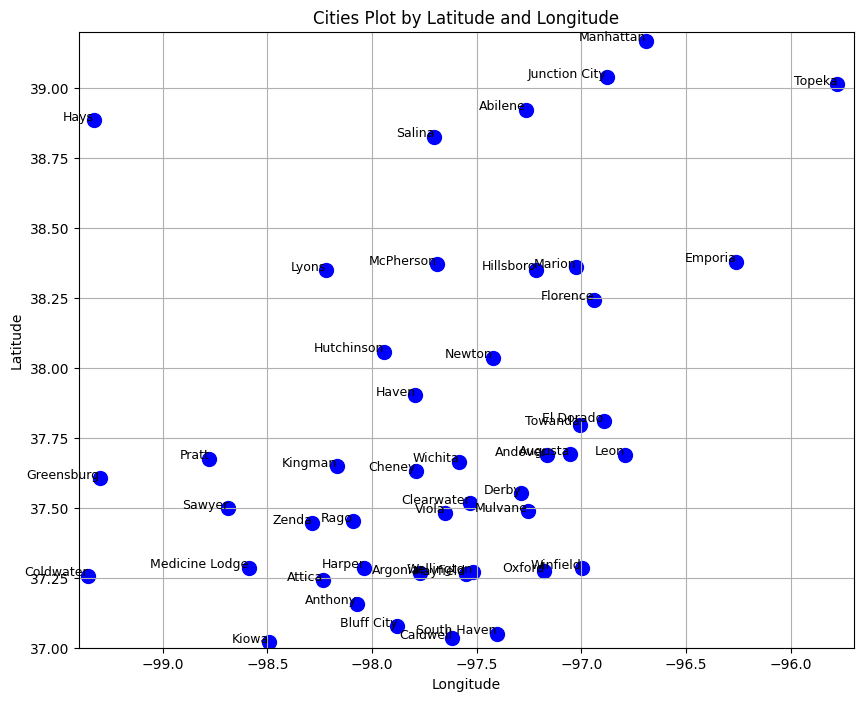

In [49]:
# Set the desired latitude and longitude range
min_lat, max_lat = 37, 39.2
min_lon, max_lon = -99.4, -95.7

# First plot: Plot the cities based on their latitude and longitude from city_coor_list
plt.figure(figsize=(10, 8))
plt.scatter(city_coor_list['longitude'], city_coor_list['latitude'], color='blue', label='City', s=100)

# Label the points with city names
for i, city in city_coor_list.iterrows():
    plt.text(city['longitude'], city['latitude'], city['city_name'], fontsize=9, ha='right')

# Set axis limits for latitude and longitude
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)

# Title and labels
plt.title('Cities Plot by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

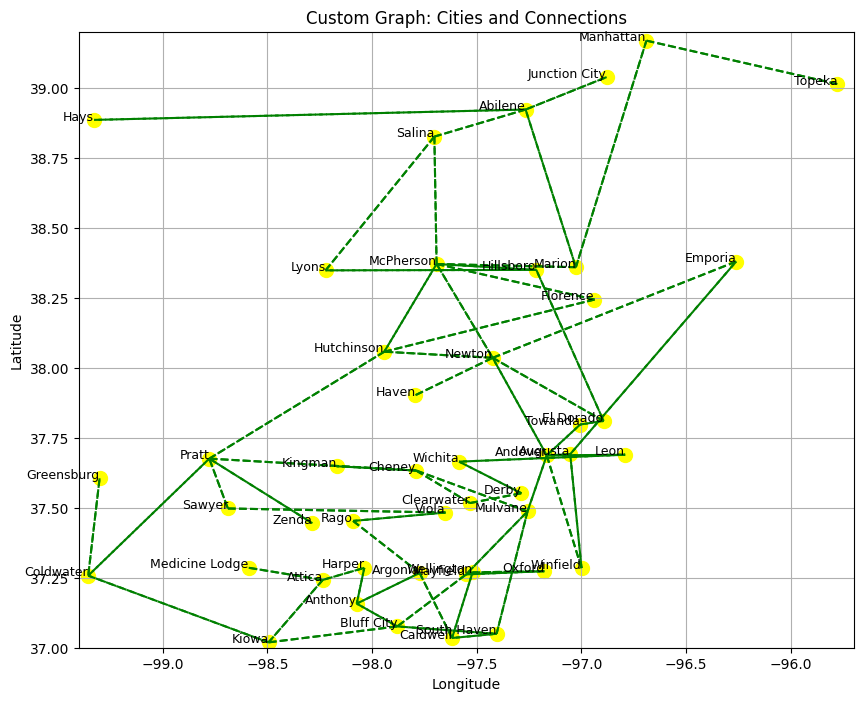

In [50]:
# Second plot: Plot the nodes (cities) and edges from the custom graph structure
plt.figure(figsize=(10, 8))

# Iterate through vertices to plot edges and nodes
for vertex in graph:
    # Plot the current vertex
    plt.scatter(vertex.longitude, vertex.latitude, color='yellow', s=100)
    plt.text(vertex.longitude, vertex.latitude, vertex.id, fontsize=9, ha='right')

    # Plot the edges to neighbors
    for neighbor_id in vertex.neighbors:
        neighbor = graph.vertices[neighbor_id]
        # Plot a line between the vertex and its neighbor
        plt.plot([vertex.longitude, neighbor.longitude], [vertex.latitude, neighbor.latitude], '--g')

# Set axis limits for latitude and longitude
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)

# Title and labels
plt.title('Custom Graph: Cities and Connections')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [51]:
def plot_traversal(path, graph, min_lat, max_lat, min_lon, max_lon):
    """
    Function to plot the traversal of a given path on the graph.

    Parameters:
    - path: List of city names representing the traversal path.
    - graph: The custom graph structure containing the vertices.
    - min_lat, max_lat: The minimum and maximum latitude for setting plot limits.
    - min_lon, max_lon: The minimum and maximum longitude for setting plot limits.
    """
    plt.figure(figsize=(10, 8))

    # Plot each node (city) along the path in yellow
    for city_name in path:
        vertex = graph.get_vertex(city_name)
        plt.scatter(vertex.longitude, vertex.latitude, color='yellow', s=100)
        plt.text(vertex.longitude, vertex.latitude, vertex.id, fontsize=9, ha='right')

    # Plot the edges (connections between consecutive cities in the path) with green dashed lines
    for i in range(len(path) - 1):
        v1 = graph.get_vertex(path[i])
        v2 = graph.get_vertex(path[i + 1])
        plt.plot([v1.longitude, v2.longitude], [v1.latitude, v2.latitude], '--g')  # Green dashed lines

    # Set axis limits for latitude and longitude
    plt.xlim(min_lon, max_lon)
    plt.ylim(min_lat, max_lat)

    # Title and labels
    plt.title('Traversal Path')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

# User Input and Menu Functions

In [52]:
# Exit commands list
exits = ["Quit", "quit", "QUIT", "Exit", "exit", "EXIT"]
# Exit condition
farewell = False


# User input and verification
def get_check_input():
  city_in = input()
  city = input_check(city_in)
  return city

def input_check(city): # modded with assist from ChatGPT
  if city in exits:
    return "Exit"
  else:
    while city not in city_coor_list['city_name'].values:
      print("Invalid city.\n")
      city = input("Enter city name: ")
      if city in exits:  # This replaced a recursion call
        return "Exit"
    return city


In [53]:
def directions(farewell):
  print("Enter the name of the starting city:\n" + "\ttype Quit to exit:\n")
  city_1 = get_check_input()
  if city_1 == "Exit":
    print("Goodbye")
    farewell = True
  else:
    print("You're starting at the city of " + city_1)

  if farewell == False:
    print("Enter the name of the ending city:\n" + "\ttype Quit to exit:\n")
    city_2 = get_check_input()
    if city_2 == "Exit":
      print("Goodbye")
      farewell = True
    else: print("You're ending at the city of " + city_2)
  else: city_2 = "Exit"
  return city_1, city_2, farewell

In [54]:
def search_method(city_1, city_2, farewell):
  print("What search method would you like to use?\n\t1)Breadth-First\n\t2)Depth-First\n\t3)Iterative Deepening DFS\n\t4)Best-First\n\t5)A*star")
  print("\t6)Choose New Cities")
  print("Type Quit to exit")
  choice = input()
  if choice in exits:
    print("Goodbye")
    farewell = True
  elif choice == "1":
    print("Breadth-First Search")
    path = bfs_search(graph, city_1, city_2)
    if path:
      plot_traversal(path, graph, min_lat, max_lat, min_lon, max_lon)
  elif choice == "2":
    print("Depth-First Search")
    path = dfs_search(graph, city_1, city_2)
    if path:
      plot_traversal(path, graph, min_lat, max_lat, min_lon, max_lon)
  elif choice == "3":
    print("Iterative Deepening DFS")
    # There is an option for setting max depth, using default == 10.
    path = iddfs_search(graph, city_1, city_2)
    if path:
      plot_traversal(path, graph, min_lat, max_lat, min_lon, max_lon)
  elif choice == "4":
    print("Best-First Search")
    path = best_first_search(graph, city_1, city_2)
    if path:
      plot_traversal(path, graph, min_lat, max_lat, min_lon, max_lon)
  elif choice == "5":
    print("A*star")
    path = a_star_search(graph, city_1, city_2)
    if path:
      plot_traversal(path, graph, min_lat, max_lat, min_lon, max_lon)
  elif choice == "6":
    print("Choose New Cities")
  else:
    while choice not in ["1","2","3","4","5","6"]:
      print("Invalid choice\nPlease enter a valid choice")
      choice = input()
  return choice, farewell

# Execution Loops

Enter the name of the starting city:
	type Quit to exit:

Hays
You're starting at the city of Hays
Enter the name of the ending city:
	type Quit to exit:

Greensburg
You're ending at the city of Greensburg
What search method would you like to use?
	1)Breadth-First
	2)Depth-First
	3)Iterative Deepening DFS
	4)Best-First
	5)A*star
	6)Choose New Cities
Type Quit to exit
1
Breadth-First Search
BFS Path: ['Hays', 'Abilene', 'Marion', 'McPherson', 'Hutchinson', 'Pratt', 'Coldwater', 'Greensburg']
Total Time: 0.000162 seconds
Total Distance: 536.03 km
Memory Usage: 0.52 MB


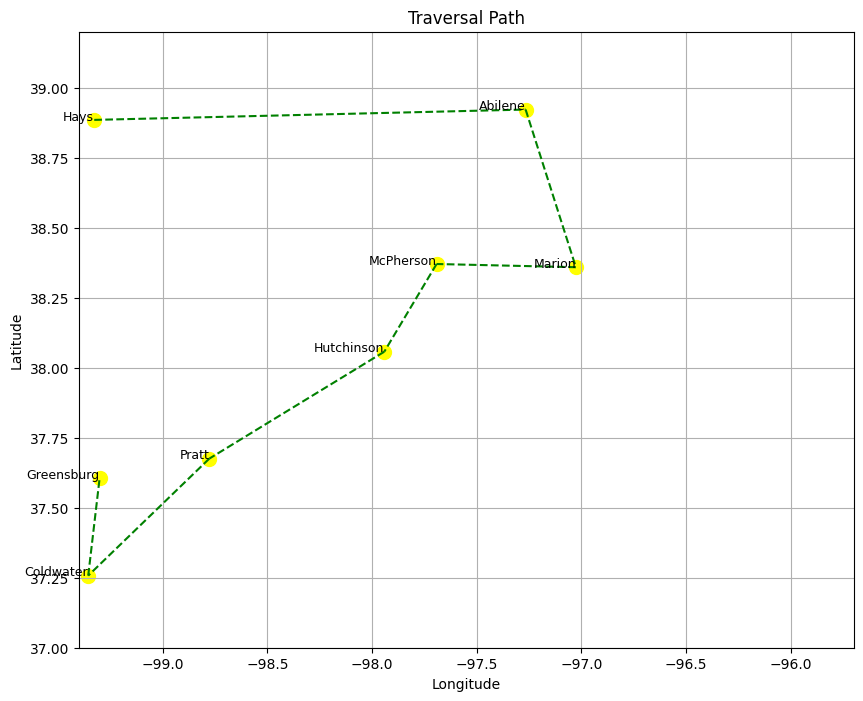

What search method would you like to use?
	1)Breadth-First
	2)Depth-First
	3)Iterative Deepening DFS
	4)Best-First
	5)A*star
	6)Choose New Cities
Type Quit to exit
2
Depth-First Search
DFS Path: ['Hays', 'Abilene', 'Salina', 'Lyons', 'Hillsboro', 'El Dorado', 'Newton', 'Andover', 'Mulvane', 'Cheney', 'Pratt', 'Sawyer', 'Viola', 'Rago', 'Argonia', 'Caldwell', 'Wellington', 'Oxford', 'Mayfield', 'Bluff City', 'Kiowa', 'Coldwater', 'Greensburg']
Total Time: 0.000106 seconds
Total Distance: 1216.45 km
Memory Usage: 0.77 MB


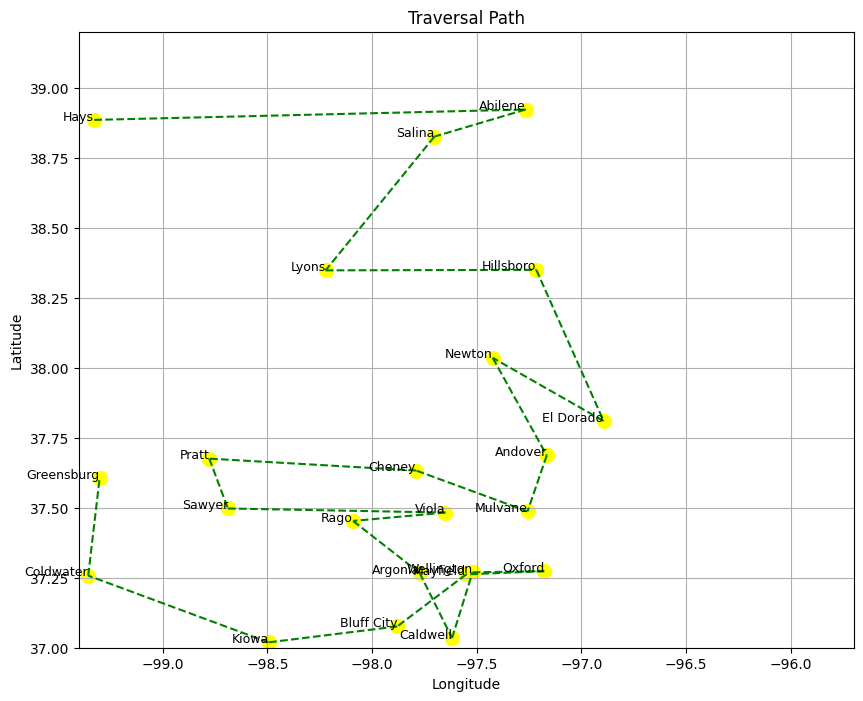

What search method would you like to use?
	1)Breadth-First
	2)Depth-First
	3)Iterative Deepening DFS
	4)Best-First
	5)A*star
	6)Choose New Cities
Type Quit to exit
4
Best-First Search
Best-First Path: ['Hays', 'Abilene', 'Salina', 'McPherson', 'Hutchinson', 'Pratt', 'Coldwater', 'Greensburg']
Total Time: 0.000246 seconds
Total Distance: 501.86 km
Memory Usage: 2.32 MB


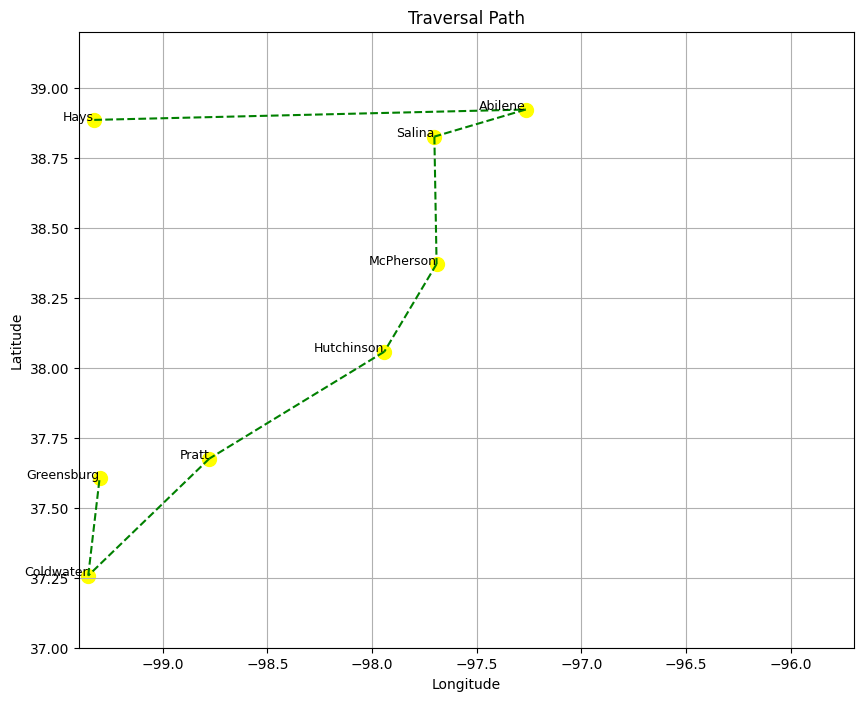

What search method would you like to use?
	1)Breadth-First
	2)Depth-First
	3)Iterative Deepening DFS
	4)Best-First
	5)A*star
	6)Choose New Cities
Type Quit to exit
6
Choose New Cities
Enter the name of the starting city:
	type Quit to exit:

Greensburg
You're starting at the city of Greensburg
Enter the name of the ending city:
	type Quit to exit:

Topeka
You're ending at the city of Topeka
What search method would you like to use?
	1)Breadth-First
	2)Depth-First
	3)Iterative Deepening DFS
	4)Best-First
	5)A*star
	6)Choose New Cities
Type Quit to exit
4
Best-First Search
Best-First Path: ['Greensburg', 'Coldwater', 'Pratt', 'Hutchinson', 'Florence', 'McPherson', 'Marion', 'Manhattan', 'Topeka']
Total Time: 0.000331 seconds
Total Distance: 583.29 km
Memory Usage: 2.32 MB


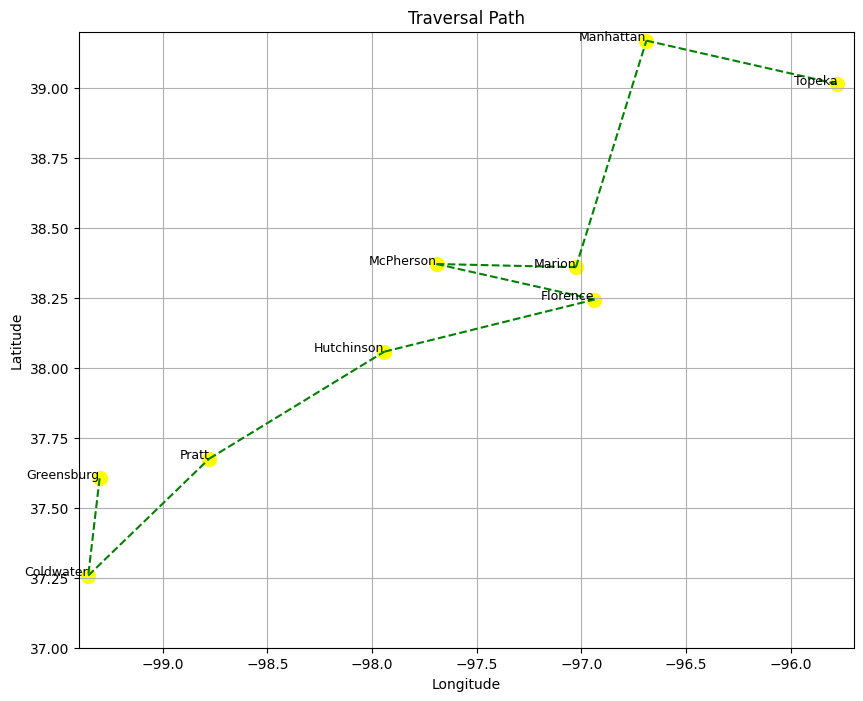

What search method would you like to use?
	1)Breadth-First
	2)Depth-First
	3)Iterative Deepening DFS
	4)Best-First
	5)A*star
	6)Choose New Cities
Type Quit to exit
1
Breadth-First Search
BFS Path: ['Greensburg', 'Coldwater', 'Pratt', 'Hutchinson', 'McPherson', 'Marion', 'Manhattan', 'Topeka']
Total Time: 0.000146 seconds
Total Distance: 466.94 km
Memory Usage: 2.32 MB


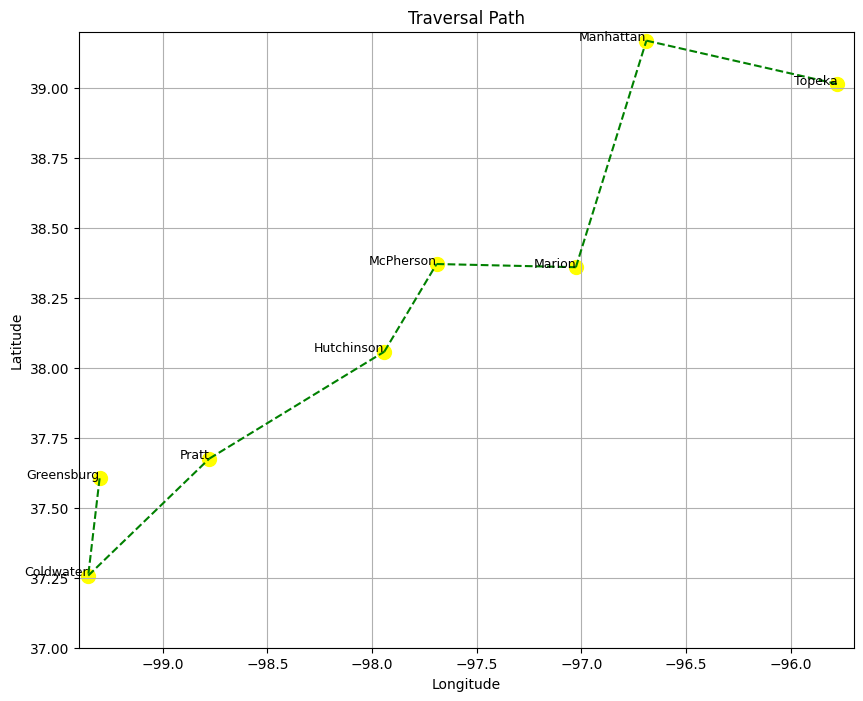

What search method would you like to use?
	1)Breadth-First
	2)Depth-First
	3)Iterative Deepening DFS
	4)Best-First
	5)A*star
	6)Choose New Cities
Type Quit to exit
5
A*star
A* Path: ['Greensburg', 'Coldwater', 'Pratt', 'Hutchinson', 'McPherson', 'Marion', 'Manhattan', 'Topeka']
Total Time: 0.000808 seconds
Total Distance: 466.94 km
Memory Usage: 2.32 MB


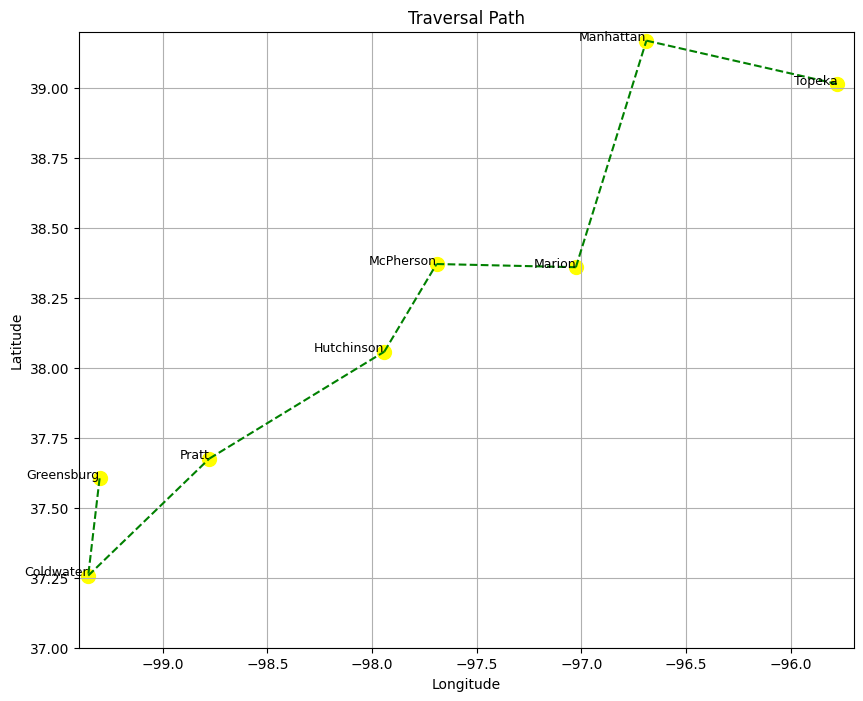

What search method would you like to use?
	1)Breadth-First
	2)Depth-First
	3)Iterative Deepening DFS
	4)Best-First
	5)A*star
	6)Choose New Cities
Type Quit to exit
quit
Goodbye


In [55]:
# Here is the initialization of the process.
farewell = False
while farewell == False:
  method = "0" # Reset method selection for repeating start/end
  city_1, city_2, farewell = directions(farewell)
  while farewell == False and method != "6":  # Fix the loop condition
    method, farewell = search_method(city_1, city_2, farewell)
